In [24]:
#定义工具
from langchain.tools import BaseTool
from pydantic import BaseModel, Field
import datetime


class GetDateInput(BaseModel):
    # format: str = Field(default="%Y-%m-%d", description="日期格式")
    pass

class GetDate(BaseTool):
    name: str = Field(default="get_date")
    description: str = Field(default="这是一个获取日期的API，可以获取当前日期")
    # args_schema: Type[BaseModel] = GetDateInput

    def _run(self) -> str:
        return datetime.datetime.now().strftime('%Y-%m-%d')
    async def _arun(self) -> str:
        raise NotImplementedError("This tool does not support async")

In [25]:

#导入大模型
from langchain.chat_models import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()

api_key = os.getenv("api_key")
base_url = os.getenv("base_url")

online_llm = ChatOpenAI(
    api_key=api_key,
    model="deepseek-r1",
    base_url=base_url,
    temperature=0
)

In [26]:
#导入建立 agent 的相关环境
from langchain.agents import initialize_agent, AgentType
from langchain.agents import Tool #定义工具信息的
from pydantic import BaseModel,Field
from langchain.tools import BaseTool
from typing import Type
import requests


time_agent = initialize_agent(
    [GetDate()],
    online_llm,
    AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True, # 处理解析错误
)

In [27]:
time_agent.run("今天几号？")



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "get_date",
  "action_input": {}
}
```
Observation: 2025-06-01
Thought:Action:
```
{
  "action": "Final Answer",
  "action_input": "今天是2025年6月1日"
}
```

> Finished chain.


'今天是2025年6月1日'

In [28]:
#导入图相关环境
from langgraph.graph import  StateGraph
from typing import  TypedDict, Annotated, List
from langgraph.graph.message import  add_messages

In [29]:
#定义消息状态信息
class State(TypedDict):
    messages: Annotated[List, add_messages]

In [30]:
#定义图信息
graph = StateGraph(State)


#定义节点函数，返回值是状态信息
def chat_node(state: State):

    result = time_agent.run(state["messages"])
    return {"messages": result}

In [31]:
#添加节点
graph.add_node('chat', chat_node)

In [32]:
import json
from langchain_core.messages import ToolMessage  # 导入工具消息类，用于封装工具执行结果

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""
    # 功能说明：实现LangGraph中执行工具调用的节点，处理AI消息中的工具请求

    def __init__(self, tools: list) -> None:
        # 工具初始化：将工具列表转换为{工具名:工具对象}的字典结构
        self.tools_by_name = {tool.name: tool for tool in tools}  

    def __call__(self, inputs: dict):
        # 节点调用入口，inputs包含消息历史记录
        if messages := inputs.get("messages", []):
            message = messages[-1]  # 获取最新AI消息（含工具调用请求）
        else:
            raise ValueError("No message found in input")
        
        outputs = []
        for tool_call in message.tool_calls:  # 遍历消息中的所有工具调用请求
            # 执行具体工具：根据工具名获取实例并传入参数
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 封装工具结果为ToolMessage，包含：
            # content: JSON序列化的执行结果
            # name: 工具标识（需与请求匹配）
            # tool_call_id: 调用ID（用于关联请求与响应）
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}  # 返回工具消息列表，供后续节点处理

# 使用示例
tool_node = BasicToolNode(tools=[GetDate()])  # 创建工具节点实例，绑定日期工具
graph.add_node("tools", tool_node)  # 将节点添加到LangGraph状态图中

In [33]:
from typing import Literal  # 类型标注模块，用于定义字面量类型

def route_tools(state: State) -> Literal["tools", "__end__"]:
    """
    工具路由决策函数，用于条件边(conditional_edge)判断：
    - 当最后一条消息包含工具调用时路由到ToolNode
    - 否则终止流程
    
    参数:
        state: 包含消息历史的状态对象，可以是列表或字典形式
    返回:
        "tools" 或 "__end__" 字面量，指示下一步节点
    """
    # 状态数据提取逻辑
    if isinstance(state, list):  # 处理列表形式的状态数据
        ai_message = state[-1]  # 获取最新AI消息
    elif messages := state.get("messages", []):  # 处理字典形式的状态数据
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # 工具调用检测逻辑
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"  # 存在工具调用时路由到工具节点
    return "__end__"  # 否则终止流程

# 构建状态图的条件边（核心控制流）
graph.add_conditional_edges(
    "chat",  # 源节点名称
    route_tools,  # 路由判断函数
    {
        "tools": "tools",      # 当返回"tools"时跳转到tools节点
        "__end__": "__end__"   # 当返回"__end__"时终止流程
    }
)

# 工具节点执行后必须返回chat节点重新决策
graph.add_edge("tools", "chat")  

# 设置状态图入口节点
graph.set_entry_point("chat")  




In [34]:
#定义记忆
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

# 将工作流实例与记忆关联
# 编译生成可执行的工作流实例
graph_builder = graph.compile(checkpointer=checkpointer)  



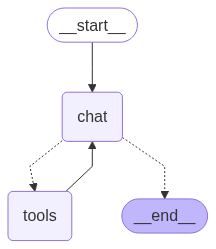

In [35]:
#可视化状态图
from IPython.display import Image, display

try:
    display(Image(graph_builder.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [40]:
# 执行工作流
from langchain_core.messages import BaseMessage


config = {
    "configurable": {
        "thread_id": "1"  
    }
}


while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph_builder.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            if isinstance(value["messages"], BaseMessage):
                print("Assistant:", value["messages"][-1].content)




> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Final Answer",
  "action_input": "您好！我是由深度求索（DeepSeek）公司开发的智能助手DeepSeek-R1。有关模型和产品的详细内容请参考官方文档。"
}
```

> Finished chain.
Goodbye!


In [41]:
graph_builder.checkpointer.get_tuple(config).checkpoint['channel_values']

{'messages': [HumanMessage(content='q', additional_kwargs={}, response_metadata={}, id='5bb8472b-7ff8-471e-a792-681d0801845c'),
  HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='79801f35-5aa5-42b3-beb8-1e001eded27d'),
  HumanMessage(content='你啊是谁', additional_kwargs={}, response_metadata={}, id='fe5a55b8-5142-476c-82a3-44c9f1af246f'),
  HumanMessage(content='您好！我是由深度求索（DeepSeek）公司开发的智能助手DeepSeek-R1。有关模型和产品的详细内容请参考官方文档。', additional_kwargs={}, response_metadata={}, id='e2f2be7b-9bb2-4a14-a843-40edaad88de8')]}

In [ ]:
graph_builder.invoke({"messages": [("user", '你是谁')]}, config)




> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Final Answer",
  "action_input": "我是一个AI助手，旨在帮助您解答问题和提供信息。当前日期是2025年6月1日。"
}
```

> Finished chain.


{'messages': [HumanMessage(content='你好', additional_kwargs={}, response_metadata={}, id='40f03de1-6aad-4b55-bc32-22358589eb7e'),
  HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='913cbc6e-973e-4e8f-be50-66be41a63915'),
  HumanMessage(content='今日时间', additional_kwargs={}, response_metadata={}, id='c9cdda4d-becb-41e8-9b31-1cd2411dfa42'),
  HumanMessage(content='当前日期是2025年6月1日。', additional_kwargs={}, response_metadata={}, id='3e465e4d-00b0-47a5-b006-b904e16e22b2'),
  HumanMessage(content='你是谁', additional_kwargs={}, response_metadata={}, id='6b35a38a-b4a2-4b06-b016-ff10a00e3be6'),
  HumanMessage(content='我是一个AI助手，旨在帮助您解答问题和提供信息。当前日期是2025年6月1日。', additional_kwargs={}, response_metadata={}, id='2301a5ae-e5db-42fa-bd47-aca098fd3f26')]}

In [42]:
events = graph_builder.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

q


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Final Answer",
  "action_input": "您好！请问有什么具体问题我可以帮助您解答吗？"
}
```

> Finished chain.
================================ Human Message =================================

您好！请问有什么具体问题我可以帮助您解答吗？
